In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp

In [2]:
def paperRewards(alpha, gamma, beta):
    num1 = 1 + (beta * np.power(1-alpha,2) * (1-gamma))
    den1 = np.exp(beta) - 1
    exp1 = num1 / den1
    
    exp2 = exp1 + (5 * alpha) + (np.power(1-alpha, 2) * gamma) 
    exp3 = (2 * np.power(alpha, 2)) / (1-2 * alpha) - (2 * np.power(alpha,2))
    
    exp4 = exp2 + exp3
    
    num2 = alpha * (1-2*alpha) * (1 - np.exp(-beta))
    den2 = 1 - 2 * np.exp(-beta) * alpha - 3 * (1 - np.exp(-beta)) * np.power(alpha,2)
    
    exp5 = num2 / den2
    
    return exp4 * exp5

In [89]:
paperRewards(1/3, 0.0, 4)

0.3571577086484553

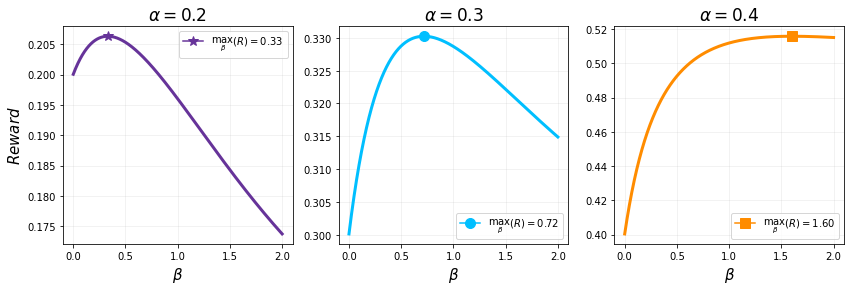

In [3]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

betas = np.arange(0.001, 2.001, 0.001)
rews20 = [paperRewards(0.2, 0, b) for b in betas]
rews30 = [paperRewards(0.3, 0, b) for b in betas]
rews40 = [paperRewards(0.4, 0, b) for b in betas]
axarr[0].plot(betas, rews20, linewidth=3, color='rebeccapurple')
axarr[1].plot(betas, rews30, linewidth=3, color='deepskyblue')
axarr[2].plot(betas, rews40, linewidth=3, color='darkorange')

max20b, max20  = betas[np.argmax(rews20)], np.max(rews20)
max30b, max30  = betas[np.argmax(rews30)], np.max(rews30)
max40b, max40  = betas[np.argmax(rews40)], np.max(rews40)

axarr[0].plot(max20b, max20, marker='*', markersize=10, color='rebeccapurple', 
              label=r'$\max_\beta(R) = {:0.2f}$'.format(max20b))
axarr[1].plot(max30b, max30, marker='o', markersize=10, color='deepskyblue', 
              label=r'$\max_\beta(R) = {:0.2f}$'.format(max30b))
axarr[2].plot(max40b, max40, marker='s', markersize=10, color='darkorange', 
              label=r'$\max_\beta(R) = {:0.2f}$'.format(max40b))

for ax in axarr:
    ax.set_xlabel(r'$\beta$', size=15)
    ax.grid(alpha=0.2)
    ax.legend()


axarr[0].set_ylabel(r'$Reward$', size=15)
axarr[0].set_title(r'$\alpha=0.2$', size=17)
axarr[1].set_title(r'$\alpha=0.3$', size=17)
axarr[2].set_title(r'$\alpha=0.4$', size=17)
plt.show()

In [4]:
# figure 8
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(0.01, 5.01, 0.01)
opt_betas = []
for alpha in alphas:
    rews = [paperRewards(alpha, 0, b) for b in betas]
    opt_betas.append(betas[np.argmax(rews)])
opt_betas = np.asarray(opt_betas)

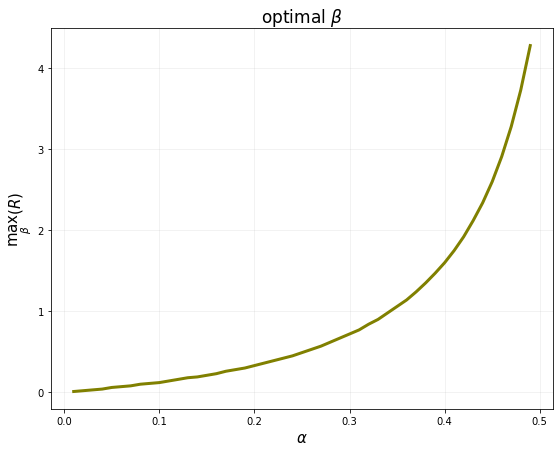

In [5]:
f, ax = plt.subplots(figsize=(9,7))

ax.plot(alphas, opt_betas, linewidth=3, color='olive')
ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'$\max_\beta{(R)}$', size=15)
ax.set_title(r'optimal $\beta$', size=17)
ax.grid(alpha=0.2)
plt.show()

In [6]:
def selfishReward(a):
    num = a * np.power(1-a, 2) * 4 * a - np.power(a, 3)
    den = 1 - a * (1 + ((2-a) * a))
    return num / den

In [7]:
# figure 10
alphas = np.arange(0.01, 0.50, 0.01)
selfishs = [selfishReward(a) for a in alphas]
betarews = []
for a in alphas:
    rews = [paperRewards(a, 0, b) for b in betas]
    betarews.append(np.max(rews))

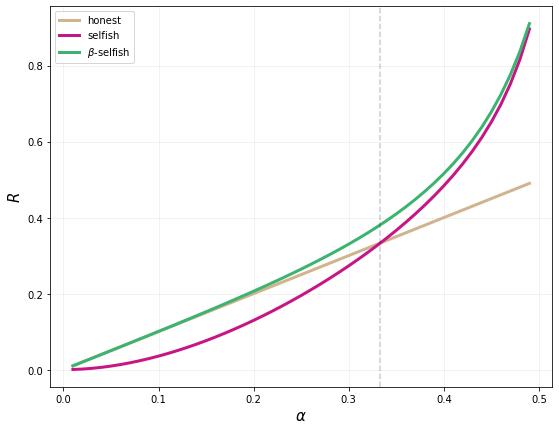

In [8]:
f, ax = plt.subplots(figsize=(9,7))

ax.plot(alphas, alphas, linewidth=3, color='tan', alpha=1, label='honest')
ax.plot(alphas, selfishs, linewidth=3, color='mediumvioletred', label='selfish')
ax.plot(alphas, betarews, linewidth=3, color='mediumseagreen', label=r'$\beta$-selfish')

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'$R$', size=15)
ax.axvline(1/3, alpha=0.2, color='k', linestyle='--')
ax.grid(alpha=0.2)
ax.legend()

plt.show()

In [9]:
# adding our rewards
def calcP1(a, b):
    num = a * (2*a-1) * (np.exp(b)-1)
    den = 3 * np.power(a,2) * (np.exp(b)-1) + (2*a) - np.exp(b)
    return num / den

def calcH(a, b):
    exp1 = (1-a) / (a * (1 - np.exp(-b)))
    exp2 = 2 * np.power(1-a, 2)
    exp3 = a * (1-a)
    return calcP1(a,b) * (exp1 + exp2 + exp3)

def calcA(a, b):
    exp1 = 2*a * (np.power(a,2) - 4*a + 2) / (1-2*a)
    exp2 = 1 / (np.exp(b) - 1)
    return calcP1(a,b) * (exp1 + exp2)

def calcA2(a, b):
    exp1 = (a * np.exp(-b)) / (a * (1 - np.exp(-b)))
    exp2 = 2 * a * (1-a)
    exp3 = np.power(a,2)
    exp4 = a * (2-a) / (1-a)
    exp5 = sum([np.power(a/(1-a), i-1) * a for i in range(3, 40)])
    return calcP1(a,b) * (exp1 + exp2 + exp3 + exp4 + exp5)

def calcAOverAH(a, b):
    return calcA(a,b) / (calcA(a,b) + calcH(a,b))

In [10]:
a, b = 0.2, 2
calcA(a,b), calcA2(a,b), calcA(a,b) - calcA2(a,b)

(0.12114265813348918, 0.1211426581334892, -2.7755575615628914e-17)

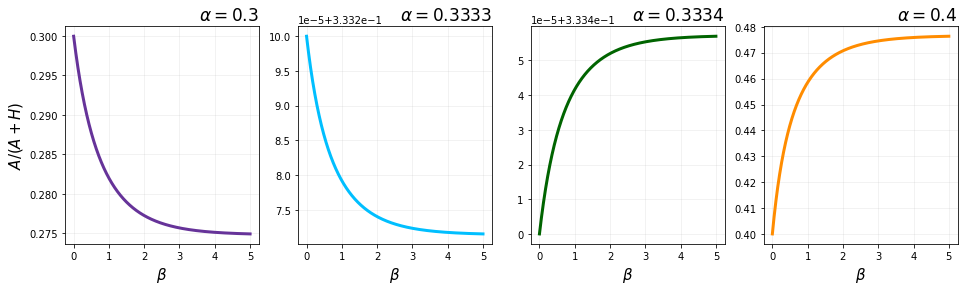

In [11]:
f, axarr = plt.subplots(ncols=4, figsize=(16,4))

betas = np.arange(0.001, 5.001, 0.001)
aover30 = [calcAOverAH(0.3, b) for b in betas]
aover33 = [calcAOverAH(0.3333, b) for b in betas]
aover34 = [calcAOverAH(0.3334, b) for b in betas]
aover40 = [calcAOverAH(0.4, b) for b in betas]
axarr[0].plot(betas, aover30, linewidth=3, color='rebeccapurple')
axarr[1].plot(betas, aover33, linewidth=3, color='deepskyblue')
axarr[2].plot(betas, aover34, linewidth=3, color='darkgreen')
axarr[3].plot(betas, aover40, linewidth=3, color='darkorange')

for ax in axarr:
    ax.set_xlabel(r'$\beta$', size=15)
    ax.grid(alpha=0.2)
#     ax.ticklabel_format(useOffset=False)


axarr[0].set_ylabel(r'$A/(A+H)$', size=15)
axarr[0].set_title(r'$\alpha=0.3$', size=17, loc='right')
axarr[1].set_title(r'$\alpha=0.3333$', size=17, loc='right')
axarr[2].set_title(r'$\alpha=0.3334$', size=17, loc='right')
axarr[3].set_title(r'$\alpha=0.4$', size=17, loc='right')
plt.show()

In [12]:
def calcTotalReward(a, b, scale=1):
    return (scale*paperRewards(a, 0, b) + calcAOverAH(a, b)) / (scale + 1)

In [13]:
# NEWFIGURE :)
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(0.01, 5.01, 0.01)
selfishs = [selfishReward(a) for a in alphas]
betarews = []
prop = 1
for a in tqdm(alphas):
    rews = [paperRewards(a, 0, b) for b in betas]
    bestBeta = betas[np.argmax(rews)]
    betarews.append(calcTotalReward(a, bestBeta, scale=prop))
fusionrs = [] 
for a in tqdm(alphas):
    rews = [calcTotalReward(a, b, scale=prop) for b in betas]
    fusionrs.append(np.max(rews))

100%|██████████| 49/49 [00:01<00:00, 26.54it/s]


In [14]:
# np.array(fusionrs) - np.array(betarews)
np.min(alphas[np.array(fusionrs) - alphas > 0])

0.25

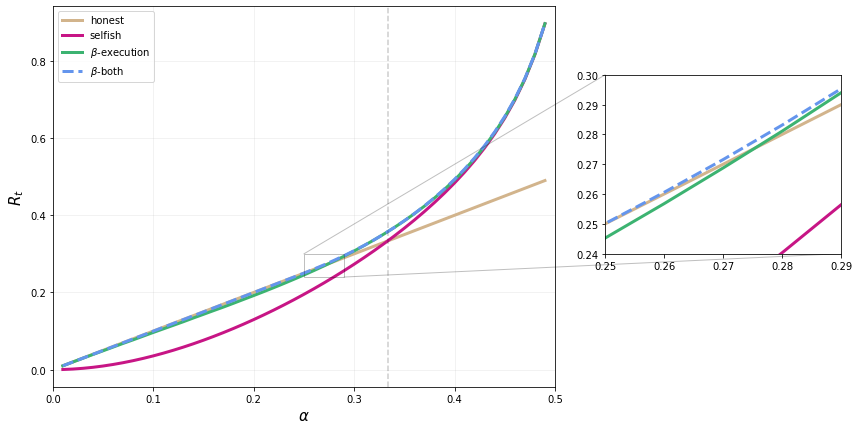

In [15]:
f, ax = plt.subplots(figsize=(9,7))

x1, x2, y1, y2 = 0.25, 0.29, 0.24, 0.3 # subregion of the original image
axins = ax.inset_axes(
    [1.1, 0.35, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2))

ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)

for a in [ax, axins]:
    a.plot(alphas, alphas, linewidth=3, color='tan', alpha=1, label='honest')
    a.plot(alphas, selfishs, linewidth=3, color='mediumvioletred', label='selfish')
    a.plot(alphas, betarews, linewidth=3, color='mediumseagreen', label=r'$\beta$-execution')
    a.plot(alphas, fusionrs, linewidth=3, color='cornflowerblue', label=r'$\beta$-both', linestyle='--')

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'$R_t$', size=15)
ax.axvline(1/3, alpha=0.2, color='k', linestyle='--')
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlim(0, 0.5)

plt.savefig('out.png', dpi=400, bbox_inches='tight')

plt.show()

In [16]:
# various scales
scales = np.arange(1, 11)
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(0.01, 5.01, 0.01)
selfishs = [selfishReward(a) for a in alphas]
betarews = []
profvals = []
for s in scales:
    fusionrs = [] 
    for a in tqdm(alphas):
        rews = [calcTotalReward(a, b, scale=s) for b in betas]
        fusionrs.append(np.max(rews))
    profvals.append(np.min(alphas[np.array(fusionrs) - alphas > 0]))

100%|██████████| 49/49 [00:01<00:00, 25.66it/s]


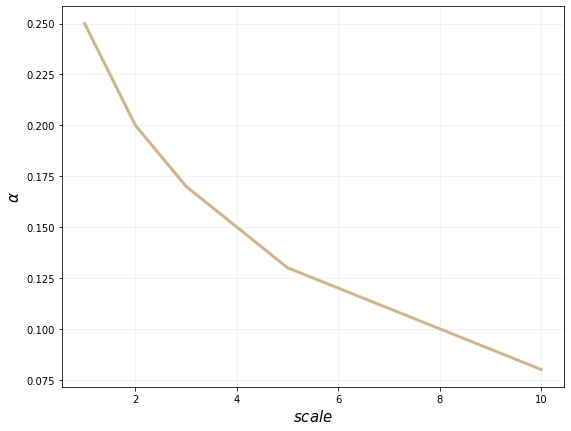

In [17]:
f, ax = plt.subplots(figsize=(9,7))

ax.plot(scales, profvals, linewidth=3, color='tan', alpha=1)
ax.set_xlabel(r'$scale$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.grid(alpha=0.2)
# ax.legend()

plt.show()

# NEW

In [98]:
# adding our rewards
def calcP1(a, b):
    num = a * (2*a-1) * (np.exp(b)-1)
    den = 3 * np.power(a,2) * (np.exp(b)-1) + (2*a) - np.exp(b)
    return num / den

def calcHGamma(a, b, gamma):
    exp1 = (1-a) / (a * (1 - np.exp(-b)))
    exp2 = np.power(1-a, 2) * (2-gamma)
    exp3 = a * (1-a)
    return (exp1 + exp2 + exp3)

def calcAGamma(a, b, gamma):
    exp1 = np.exp(-b) / (a * (1-np.exp(-b)))
    exp2 = 2 - a + ((2-a)/(1-a))
    exp3 = np.power(1-a, 2) * gamma / a
    exp4 = np.power(a,2) / ((1-2*a)*(1-a))
    return a * (exp1 + exp2 + exp3 + exp4)

def calcAOverAHGamma(a, b, gamma):
    return calcAGamma(a,b,gamma) / (calcAGamma(a,b,gamma) + calcHGamma(a,b,gamma))

In [104]:
calcAGamma(1/3, 1, 0.)

2.137532262424882

In [100]:
def calcTotalRewardGamma(a, b, gamma, scale=1):
    return (scale*paperRewards(a, gamma, b) + calcAOverAHGamma(a, b, gamma)) / (scale + 1)

In [101]:
# NEWFIGURE #2 :)
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(0.01, 5.01, 0.01)
# gammas = np.array([0, 0.5, 1])
selfishs = [selfishReward(a) for a in alphas]
betarews = []
prop = 0.5
gamma = 0.1
for a in tqdm(alphas):
    rews = [paperRewards(a, gamma, b) for b in betas]
    bestBeta = betas[np.argmax(rews)]
    betarews.append(calcTotalRewardGamma(a, bestBeta, gamma, scale=prop))
fusionrs = [] 
for a in tqdm(alphas):
    rews = [calcTotalRewardGamma(a, b, gamma, scale=prop) for b in betas]
    fusionrs.append(np.max(rews))

100%|██████████| 49/49 [00:01<00:00, 35.04it/s]


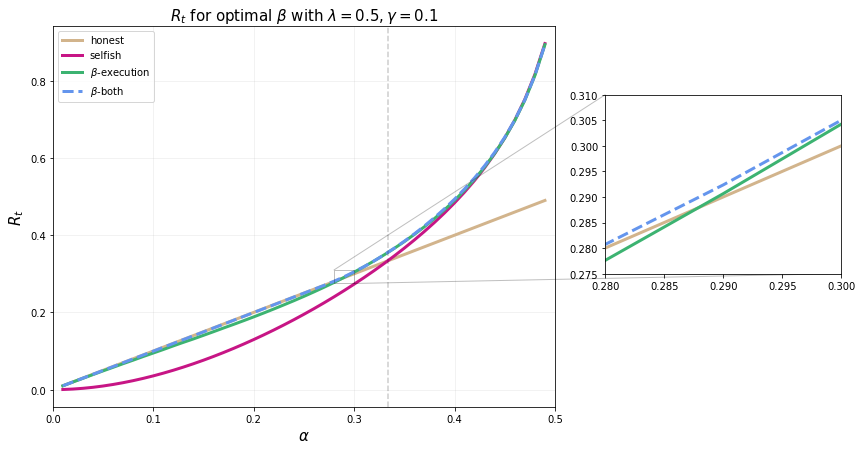

In [102]:
f, ax = plt.subplots(figsize=(9,7))

x1, x2, y1, y2 = 0.28, 0.3, 0.275, 0.31 # subregion of the original image
axins = ax.inset_axes(
    [1.1, 0.35, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2))

ax.indicate_inset_zoom(axins, edgecolor="black", label=None, alpha=0.25)

for a in [ax, axins]:
    a.plot(alphas, alphas, linewidth=3, color='tan', alpha=1, label='honest')
    a.plot(alphas, selfishs, linewidth=3, color='mediumvioletred', label='selfish')
    a.plot(alphas, betarews, linewidth=3, color='mediumseagreen', label=r'$\beta$-execution')
    a.plot(alphas, fusionrs, linewidth=3, color='cornflowerblue', label=r'$\beta$-both', linestyle='--')

ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'$R_t$', size=15)
ax.axvline(1/3, alpha=0.2, color='k', linestyle='--')
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlim(0, 0.5)
ax.set_title(r'$R_t$ for optimal $\beta$ with $\lambda=0.5, \gamma=0.1$', size=15)

plt.savefig('out.png', dpi=400, bbox_inches='tight')

plt.show()

In [22]:
np.min(alphas[np.array(fusionrs) - alphas > 0]), np.min(alphas[np.array(selfishs) - alphas > 0]),

(0.27, 0.34)

In [23]:
def compToHonest(vals):
    return np.min(alphas[np.array(vals) - alphas > 0])

In [24]:
compToHonest(fusionrs), compToHonest(selfishs), compToHonest(betarews)

(0.27, 0.34, 0.29000000000000004)

In [25]:
def selfishRewardGamma(a, gamma):
    num = a * np.power(1-a, 2) * (4*a + gamma*(1-2*a)) - np.power(a,3)
    den = 1 - a * (1 + (2-a)*a)
    return num/den

In [26]:
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.001)
selfishRes = []
for g in tqdm(gammas):
    vals = selfishRewardGamma(alphas, g)
    selfishRes.append(compToHonest(vals))
selfishRes = np.array(selfishRes)

100%|██████████| 99/99 [00:00<00:00, 9066.09it/s]


In [27]:
scales = [0.5, 1, 2]
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.001)
betas = np.arange(0.01, 5.01, 0.01)
fusionRes = [] 
for scale in scales:
    temp = []
    for g in tqdm(gammas):
        for a in alphas:
            rews = calcTotalRewardGamma(a, betas, g, scale=scale)
            if np.max(rews) > a:
                temp.append(a)
                break
    fusionRes.append(temp)
fusionRes = np.array(fusionRes)

100%|██████████| 99/99 [00:02<00:00, 40.77it/s]


In [40]:
scales = [0.5, 1, 2]
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.001)
betas = np.arange(0.01, 5.01, 0.01)
execRes = [] 
for scale in scales:
    temp = []
    for g in tqdm(gammas):
        for a in alphas:
            rews = paperRewards(a, g, betas)
            bestBeta = betas[np.argmax(rews)]
            if calcTotalRewardGamma(a, bestBeta, g, scale=scale) > a:
                temp.append(a)
                break        
    execRes.append(temp)
execRes = np.array(execRes)

100%|██████████| 99/99 [00:02<00:00, 46.59it/s]


In [84]:
calcTotalRewardGamma(0.3333333, 20, 0, scale=0.)

0.33333327142857516

In [88]:
calcTotalRewardGamma(1/3, 1, 0.0, scale=1.)

0.35720183069374023

In [41]:
execRes.shape, fusionRes.shape

((3, 99), (3, 99))

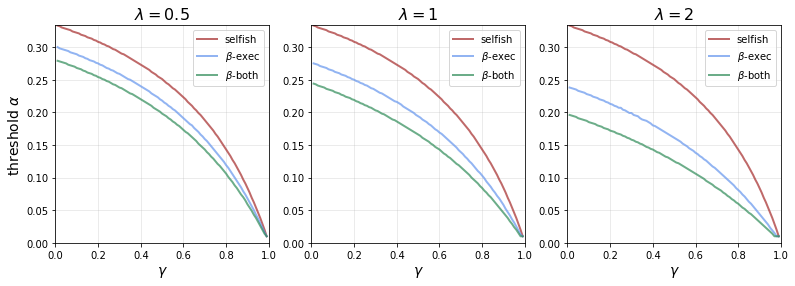

In [42]:
f, axarr = plt.subplots(ncols=3, figsize=(13,4))

for i in range(3):
    axarr[i].plot(gammas, selfishRes, color='brown', linewidth=2, alpha=0.7, label='selfish')
    axarr[i].plot(gammas, execRes[i], color='cornflowerblue', linewidth=2, alpha=0.7, label=r'$\beta$-exec')
    axarr[i].plot(gammas, fusionRes[i], color='seagreen', linewidth=2, alpha=0.7, label=r'$\beta$-both')
    
for ax in axarr:
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$\gamma$', size=14)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1/3)
axarr[0].set_ylabel(r'threshold $\alpha$', size=14)

axarr[0].set_title(r'$\lambda=0.5$', size=16)
axarr[1].set_title(r'$\lambda=1$', size=16)
axarr[2].set_title(r'$\lambda=2$', size=16)

# plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')

plt.show()

In [31]:
# figure 8, with beta-both

alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(0.01, 30.01, 0.001)

opt_beta_exec = []
for gamma in [0, 0.25, 0.5]:
    temp = []
    for alpha in tqdm(alphas):
        rews = paperRewards(alpha, gamma, betas)
        temp.append(betas[np.argmax(rews)])
    opt_beta_exec.append(temp)
opt_beta_exec = np.asarray(opt_beta_exec)


opt_beta_both = []
for gamma in [0, 0.25, 0.5]:
    temp1 = []
    for scale in [0.5, 1, 2]:
        temp2 = []
        for alpha in tqdm(alphas):
            rews = calcTotalRewardGamma(alpha, betas, gamma, scale=scale)
            temp2.append(betas[np.argmax(rews)])
        temp1.append(temp2)
    opt_beta_both.append(temp1)
opt_beta_both = np.asarray(opt_beta_both)

opt_beta_exec.shape, opt_beta_both.shape

100%|██████████| 49/49 [00:00<00:00, 231.43it/s]


((3, 49), (3, 3, 49))

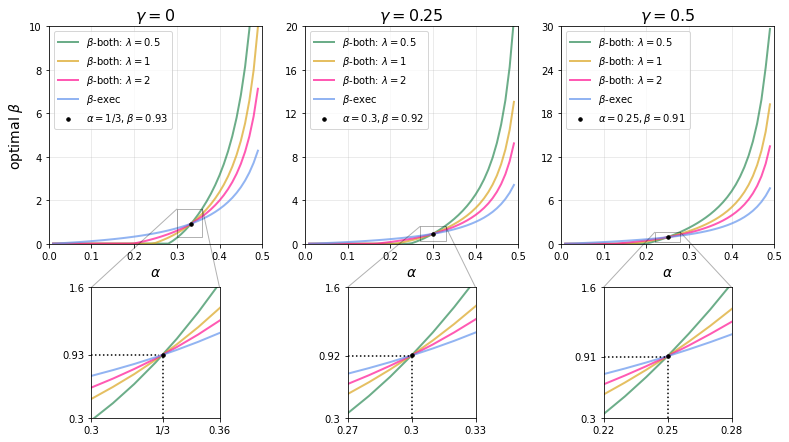

In [34]:
f, axarr = plt.subplots(ncols=3, figsize=(13,4))

axins0 = axarr[0].inset_axes([0.2, -0.8, 0.6, 0.6], xlim=(0.3, 0.36), ylim=(0.3, 1.6))
axins0.set_xticks([0.3, 1/3, 0.36])
axins0.set_xticklabels(['0.3', '1/3', '0.36'])
axins0.set_yticks([0.3, 0.93, 1.6])
axins0.set_yticklabels(['0.3', '0.93', '1.6'])
axarr[0].indicate_inset_zoom(axins0, edgecolor="black", label=None, alpha=0.3)

axins1 = axarr[1].inset_axes([0.2, -0.8, 0.6, 0.6], xlim=(0.27, 0.33), ylim=(0.3, 1.6))
axins1.set_xticks([0.27, 0.3, 0.33])
axins1.set_xticklabels(['0.27', '0.3', '0.33'])
axins1.set_yticks([0.3, 0.92, 1.6])
axins1.set_yticklabels(['0.3', '0.92', '1.6'])
axarr[1].indicate_inset_zoom(axins1, edgecolor="black", label=None, alpha=0.3)

axins2= axarr[2].inset_axes([0.2, -0.8, 0.6, 0.6], xlim=(0.22, 0.28), ylim=(0.3, 1.6))
axins2.set_xticks([0.22, 0.25, 0.28])
axins2.set_xticklabels(['0.22', '0.25', '0.28'])
axins2.set_yticks([0.3, 0.91, 1.6])
axins2.set_yticklabels(['0.3', '0.91', '1.6'])
axarr[2].indicate_inset_zoom(axins2, edgecolor="black", label=None, alpha=0.3)


for ax in [axarr[0], axins0]:
    ax.plot(alphas, opt_beta_both[0,0], color='seagreen', linewidth=2, alpha=0.7, label=r'$\beta$-both: $\lambda=0.5$')
    ax.plot(alphas, opt_beta_both[0,1], color='goldenrod', linewidth=2, alpha=0.7, label=r'$\beta$-both: $\lambda=1$')
    ax.plot(alphas, opt_beta_both[0,2], color='deeppink', linewidth=2, alpha=0.7, label=r'$\beta$-both: $\lambda=2$')
    ax.plot(alphas, opt_beta_exec[0], color='cornflowerblue', linewidth=2, alpha=0.7, label=r'$\beta$-exec')
    gamma0beta = betas[np.argmax(paperRewards(1/3, 0, betas))]
    ax.scatter(1/3, gamma0beta, marker='o', color='k', s=12, zorder=5,
                  label=r'$\alpha=1/3,\beta=${:0.2f}'.format(gamma0beta))

for ax in [axarr[1], axins1]:
    ax.plot(alphas, opt_beta_both[1,0], color='seagreen', linewidth=2, alpha=0.7, label=r'$\beta$-both: $\lambda=0.5$')
    ax.plot(alphas, opt_beta_both[1,1], color='goldenrod', linewidth=2, alpha=0.7, label=r'$\beta$-both: $\lambda=1$')
    ax.plot(alphas, opt_beta_both[1,2], color='deeppink', linewidth=2, alpha=0.7, label=r'$\beta$-both: $\lambda=2$')
    ax.plot(alphas, opt_beta_exec[1], color='cornflowerblue', linewidth=2, alpha=0.7, label=r'$\beta$-exec')
    gamma25beta = betas[np.argmax(paperRewards(0.3, .25, betas))]
    ax.scatter(0.3, gamma25beta, marker='o', color='k', s=12, zorder=5,
                  label=r'$\alpha=0.3,\beta=${:0.2f}'.format(gamma25beta))

for ax in [axarr[2], axins2]:
    ax.plot(alphas, opt_beta_both[2,0], color='seagreen', linewidth=2, alpha=0.7, label=r'$\beta$-both: $\lambda=0.5$')
    ax.plot(alphas, opt_beta_both[2,1], color='goldenrod', linewidth=2, alpha=0.7, label=r'$\beta$-both: $\lambda=1$')
    ax.plot(alphas, opt_beta_both[2,2], color='deeppink', linewidth=2, alpha=0.7, label=r'$\beta$-both: $\lambda=2$')
    ax.plot(alphas, opt_beta_exec[2], color='cornflowerblue', linewidth=2, alpha=0.7, label=r'$\beta$-exec')
    gamma50beta = betas[np.argmax(paperRewards(0.25, .5, betas))]
    ax.scatter(0.25, gamma50beta, marker='o', color='k', s=12, zorder=5,
                  label=r'$\alpha=0.25,\beta=${:0.2f}'.format(gamma50beta))

for ax in axarr:
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$\alpha$', size=14)

    
axarr[0].set_ylabel(r'optimal $\beta$', size=14)
axarr[0].set_xlim(0,1/2)
axarr[0].set_ylim(0,10)
axarr[1].set_xlim(0,1/2)
axarr[1].set_ylim(0,20)
ticks = np.arange(0, 21, 4)
axarr[1].set_yticks(ticks)
axarr[2].set_xlim(0,1/2)
ticks = np.arange(0, 31, 6)
axarr[2].set_yticks(ticks)
axarr[2].set_ylim(0,30)

axarr[0].set_title(r'$\gamma=0$', size=16)
axarr[1].set_title(r'$\gamma=0.25$', size=16)
axarr[2].set_title(r'$\gamma=0.5$', size=16)

axins0.axvline(1/3, color='k', ymin=0, ymax=0.48, linestyle='dotted')
axins0.axhline(0.93, color='k', xmin=0, xmax=0.53, linestyle='dotted')
axins1.axvline(0.3, color='k', ymin=0, ymax=0.48, linestyle='dotted')
axins1.axhline(0.92, color='k', xmin=0, xmax=0.5, linestyle='dotted')
axins2.axvline(0.25, color='k', ymin=0, ymax=0.48, linestyle='dotted')
axins2.axhline(0.91, color='k', xmin=0, xmax=0.5, linestyle='dotted')

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show()

In [87]:
alphas = np.arange(0.01, 0.50, 0.001)
vals = selfishRewardGamma(alphas, 0)
print(compToHonest(vals))

vals = selfishRewardGamma(alphas, 0.25)
print(compToHonest(vals))

vals = selfishRewardGamma(alphas, 0.5)
print(compToHonest(vals))

0.33399999999999974
0.30099999999999977
0.2509999999999998


In [39]:
# Define the symbols
p1, alpha, beta, delta = sp.symbols('p1 alpha beta delta')

# Define the equation
equation = sp.Eq(p1 / (alpha * (1 - 1/beta**delta)) + (1 - alpha) * p1 + alpha * p1 + p1 + p1 * (1 - alpha) * alpha / ((alpha - 1) * (2 * alpha - 1)), 1)

# Solve for p1
solution = sp.solve(equation, p1, dict=True)
solution

[{p1: alpha*(2*alpha*beta**delta - 2*alpha - beta**delta + 1)/(3*alpha**2*beta**delta - 3*alpha**2 + 2*alpha - beta**delta)}]

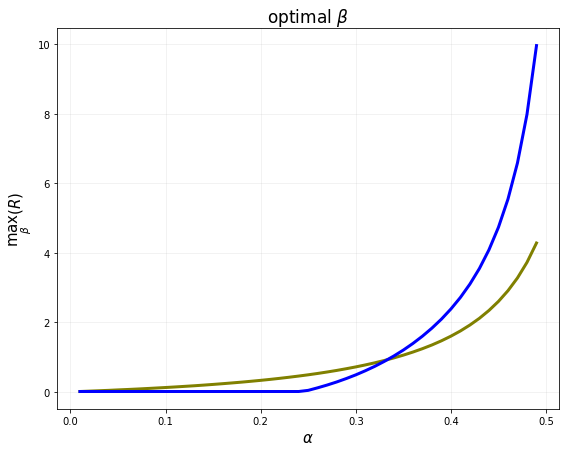

In [53]:
f, ax = plt.subplots(figsize=(9,7))

ax.plot(alphas, opt_beta_exec, linewidth=3, color='olive')
ax.plot(alphas, opt_beta_both, linewidth=3, color='blue')
ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'$\max_\beta{(R)}$', size=15)
ax.set_title(r'optimal $\beta$', size=17)
ax.grid(alpha=0.2)
plt.show()

In [ ]:
# figure 8
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(0.01, 5.01, 0.01)
opt_betas = []
for alpha in alphas:
    rews = [paperRewards(alpha, 0, b) for b in betas]
    opt_betas.append(betas[np.argmax(rews)])
opt_betas = np.asarray(opt_betas)

f, ax = plt.subplots(figsize=(9,7))

ax.plot(alphas, opt_betas, linewidth=3, color='olive')
ax.set_xlabel(r'$\alpha$', size=15)
ax.set_ylabel(r'$\max_\beta{(R)}$', size=15)
ax.set_title(r'optimal $\beta$', size=17)
ax.grid(alpha=0.2)
plt.show()

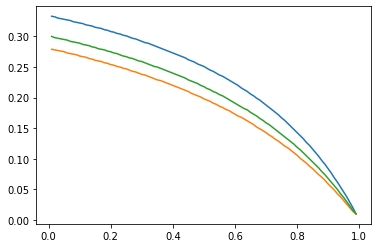

In [201]:
plt.plot(gammas, selfishRes)
plt.plot(gammas, fusionRes)
plt.plot(gammas, execRes)

In [ ]:
scales = np.arange(1, 11)
alphas = np.arange(0.01, 0.50, 0.01)
betas = np.arange(0.01, 5.01, 0.01)


In [26]:
alpha = 0.4
iters = int(1e6)

In [27]:
# selfish policy
state = 0
attacker_rews = 0
for x in tqdm(range(iters)):
    winner = np.random.choice([0, 1], p=[1-alpha, alpha])
    if state == 1 and winner == 0:
        tiebreak = np.random.choice([0, 1], p=[1-alpha, alpha])
        if tiebreak: 
            attacker_rews += 2
        state = 0
    elif state == 2 and winner == 0:
        attacker_rews += 2
        state == 0
    elif state == 0 and winner == 0:
        state += 1
    elif winner == 1:
        state += 1
    elif winner == 0:
        state -= 1
    else:
        raise KeyError

attacker_rews / iters

100%|██████████| 1000000/1000000 [00:30<00:00, 32274.17it/s]


0.397828